# Notebook 12: Variational Autoencoders (VAEs)

## Learning Objectives

By the end of this notebook, you will:
1. Understand autoencoders and their limitations for generation
2. Master VAE theory: ELBO, KL divergence, and the reparameterization trick
3. Implement VAEs from scratch and train on MNIST
4. Explore the latent space and generate new samples

**Prerequisites**: Notebooks 01-04 (PyTorch fundamentals, training loops)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Reproducibility
torch.manual_seed(42)

Using device: cuda


---
## 1. Autoencoders: Compression and Reconstruction

An **autoencoder** learns to compress data into a lower-dimensional representation (encoding) and reconstruct it back (decoding).

```
Input x → [Encoder] → Latent z → [Decoder] → Reconstruction x̂
```

The bottleneck forces the network to learn meaningful features.

In [2]:
class Autoencoder(nn.Module):
    """Simple autoencoder for MNIST (28x28 = 784 dimensions)."""
    
    def __init__(self, latent_dim=32):
        super().__init__()
        self.latent_dim = latent_dim
        
        # Encoder: 784 -> 256 -> 128 -> latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        
        # Decoder: latent_dim -> 128 -> 256 -> 784
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid()  # Output in [0, 1] for pixel values
        )
    
    def encode(self, x):
        return self.encoder(x.view(-1, 784))
    
    def decode(self, z):
        return self.decoder(z).view(-1, 1, 28, 28)
    
    def forward(self, x):
        z = self.encode(x)
        return self.decode(z), z

In [3]:
# Load MNIST
transform = transforms.ToTensor()
train_dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('../data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

In [4]:
def train_autoencoder(model, train_loader, epochs=10, lr=1e-3):
    """Train autoencoder with MSE reconstruction loss."""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    
    for epoch in range(epochs):
        total_loss = 0
        for x, _ in train_loader:
            x = x.to(device)
            
            x_recon, _ = model(x)
            loss = F.mse_loss(x_recon, x)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")
    
    return model

# Train
ae = Autoencoder(latent_dim=32).to(device)
ae = train_autoencoder(ae, train_loader, epochs=10)

Epoch 1/10, Loss: 0.0511
Epoch 2/10, Loss: 0.0245
Epoch 3/10, Loss: 0.0185
Epoch 4/10, Loss: 0.0154
Epoch 5/10, Loss: 0.0135
Epoch 6/10, Loss: 0.0122
Epoch 7/10, Loss: 0.0111
Epoch 8/10, Loss: 0.0103
Epoch 9/10, Loss: 0.0096
Epoch 10/10, Loss: 0.0091


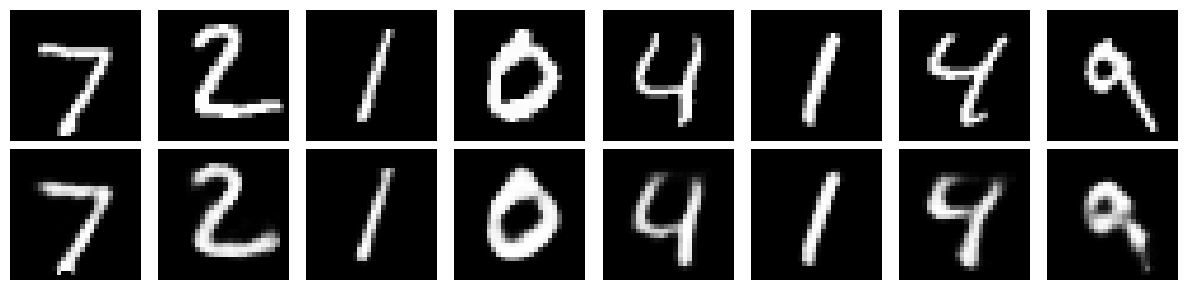

In [5]:
def visualize_reconstructions(model, test_loader, n=8):
    """Show original images and their reconstructions."""
    model.eval()
    x, _ = next(iter(test_loader))
    x = x[:n].to(device)
    
    with torch.no_grad():
        x_recon, _ = model(x)
    
    fig, axes = plt.subplots(2, n, figsize=(n*1.5, 3))
    for i in range(n):
        axes[0, i].imshow(x[i].cpu().squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(x_recon[i].cpu().squeeze(), cmap='gray')
        axes[1, i].axis('off')
    axes[0, 0].set_ylabel('Original')
    axes[1, 0].set_ylabel('Reconstructed')
    plt.tight_layout()
    plt.show()

visualize_reconstructions(ae, test_loader)

### The Problem with Standard Autoencoders for Generation

Autoencoders learn to reconstruct, but their latent space is **not structured for generation**:

Epoch 1/15, Loss: 0.0594
Epoch 2/15, Loss: 0.0465
Epoch 3/15, Loss: 0.0435
Epoch 4/15, Loss: 0.0420
Epoch 5/15, Loss: 0.0409
Epoch 6/15, Loss: 0.0402
Epoch 7/15, Loss: 0.0396
Epoch 8/15, Loss: 0.0390
Epoch 9/15, Loss: 0.0386
Epoch 10/15, Loss: 0.0382
Epoch 11/15, Loss: 0.0379
Epoch 12/15, Loss: 0.0377
Epoch 13/15, Loss: 0.0374
Epoch 14/15, Loss: 0.0372
Epoch 15/15, Loss: 0.0370


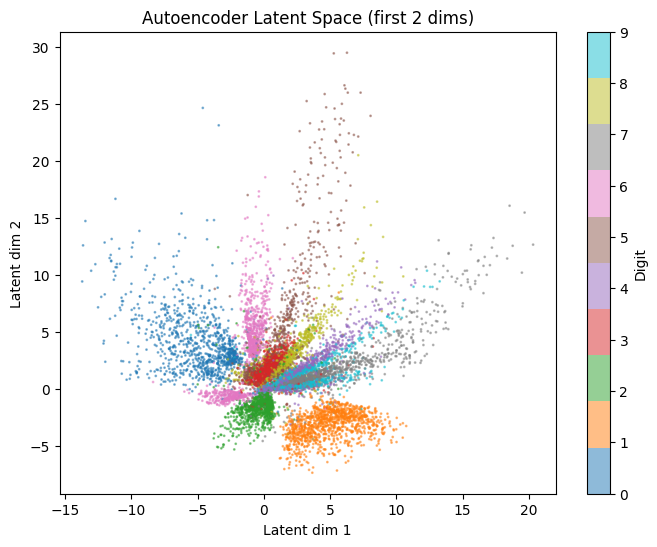

In [6]:
def visualize_latent_space_2d(model, test_loader):
    """Visualize 2D latent space colored by digit class."""
    model.eval()
    latents, labels = [], []
    
    with torch.no_grad():
        for x, y in test_loader:
            _, z = model(x.to(device))
            latents.append(z[:, :2].cpu())  # Take first 2 dimensions
            labels.append(y)
    
    latents = torch.cat(latents).numpy()
    labels = torch.cat(labels).numpy()
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='tab10', alpha=0.5, s=1)
    plt.colorbar(scatter, label='Digit')
    plt.xlabel('Latent dim 1')
    plt.ylabel('Latent dim 2')
    plt.title('Autoencoder Latent Space (first 2 dims)')
    plt.show()

# Train a 2D autoencoder for visualization
ae_2d = Autoencoder(latent_dim=2).to(device)
ae_2d = train_autoencoder(ae_2d, train_loader, epochs=15)
visualize_latent_space_2d(ae_2d, test_loader)

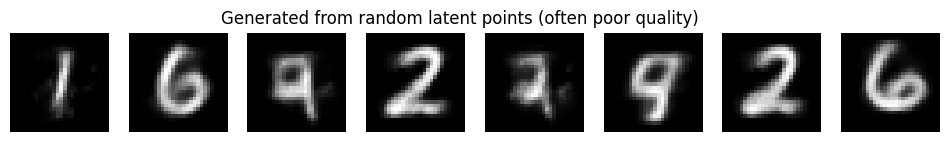

In [7]:
# Try generating from random latent points
ae_2d.eval()
with torch.no_grad():
    # Random points - may hit "holes" in latent space
    random_z = torch.randn(8, 2).to(device) * 3
    generated = ae_2d.decode(random_z)

fig, axes = plt.subplots(1, 8, figsize=(12, 1.5))
for i in range(8):
    axes[i].imshow(generated[i].cpu().squeeze(), cmap='gray')
    axes[i].axis('off')
plt.suptitle('Generated from random latent points (often poor quality)')
plt.show()

**Key issues with autoencoders for generation:**
1. **Holes in latent space**: Random samples may decode to nonsense
2. **No probabilistic interpretation**: Can't sample meaningfully
3. **Discontinuous**: Similar latent points may decode to very different outputs

---
## 2. VAE Theory: Learning a Probabilistic Latent Space

VAEs fix these issues by:
1. **Encoding to a distribution** (mean μ and variance σ²), not a point
2. **Regularizing** the latent space to be close to a standard normal N(0, I)

### The VAE Objective: Evidence Lower Bound (ELBO)

$$\mathcal{L} = \underbrace{\mathbb{E}_{q(z|x)}[\log p(x|z)]}_{\text{Reconstruction}} - \underbrace{D_{KL}(q(z|x) \| p(z))}_{\text{Regularization}}$$

Where:
- $q(z|x)$ = encoder (approximate posterior): $\mathcal{N}(\mu(x), \sigma^2(x))$
- $p(x|z)$ = decoder (likelihood)
- $p(z)$ = prior: $\mathcal{N}(0, I)$

### KL Divergence for Gaussians (Closed Form)

For $q = \mathcal{N}(\mu, \sigma^2)$ and $p = \mathcal{N}(0, 1)$:

$$D_{KL}(q \| p) = -\frac{1}{2} \sum_{j=1}^{J} (1 + \log\sigma_j^2 - \mu_j^2 - \sigma_j^2)$$

In [8]:
def kl_divergence(mu, logvar):
    """
    KL divergence between N(mu, sigma^2) and N(0, 1).
    
    Args:
        mu: Mean of approximate posterior [batch, latent_dim]
        logvar: Log variance (more numerically stable than variance)
    
    Returns:
        KL divergence summed over latent dimensions, averaged over batch
    """
    # KL = -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    return kl.mean()

# Example: KL divergence increases as we move away from N(0,1)
mu_test = torch.tensor([[0.0, 0.0], [1.0, 1.0], [2.0, 2.0]])
logvar_test = torch.zeros_like(mu_test)

for i, m in enumerate(mu_test):
    kl = kl_divergence(m.unsqueeze(0), logvar_test[i].unsqueeze(0))
    print(f"μ = {m.tolist()}, KL = {kl.item():.4f}")

μ = [0.0, 0.0], KL = 0.0000
μ = [1.0, 1.0], KL = 1.0000
μ = [2.0, 2.0], KL = 4.0000


### The Reparameterization Trick

**Problem**: Sampling $z \sim \mathcal{N}(\mu, \sigma^2)$ is not differentiable.

**Solution**: Reparameterize as $z = \mu + \sigma \cdot \epsilon$ where $\epsilon \sim \mathcal{N}(0, 1)$

This moves the randomness outside the computational graph!

In [9]:
def reparameterize(mu, logvar):
    """
    Reparameterization trick: z = mu + std * epsilon
    
    Args:
        mu: Mean [batch, latent_dim]
        logvar: Log variance [batch, latent_dim]
    
    Returns:
        Sampled z with gradients flowing through mu and logvar
    """
    std = torch.exp(0.5 * logvar)  # sigma = exp(0.5 * log(sigma^2))
    eps = torch.randn_like(std)    # epsilon ~ N(0, 1)
    return mu + std * eps

# Verify gradients flow through
mu = torch.tensor([[1.0, 2.0]], requires_grad=True)
logvar = torch.tensor([[0.0, 0.0]], requires_grad=True)

z = reparameterize(mu, logvar)
loss = z.sum()
loss.backward()

print(f"z = {z.detach()}")
print(f"∂loss/∂μ = {mu.grad}")  # Should be [1, 1]
print(f"∂loss/∂logvar exists: {logvar.grad is not None}")

z = tensor([[0.9566, 3.1504]])
∂loss/∂μ = tensor([[1., 1.]])
∂loss/∂logvar exists: True


---
## 3. VAE Implementation

Now let's implement a complete VAE:

In [10]:
class VAE(nn.Module):
    """Variational Autoencoder for MNIST."""
    
    def __init__(self, latent_dim=20):
        super().__init__()
        self.latent_dim = latent_dim
        
        # Encoder outputs mu and logvar (2 * latent_dim)
        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        """Encode input to latent distribution parameters."""
        h = self.encoder(x.view(-1, 784))
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        """Sample from latent distribution using reparameterization trick."""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + std * eps
    
    def decode(self, z):
        """Decode latent vector to reconstruction."""
        return self.decoder(z).view(-1, 1, 28, 28)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Test
vae = VAE(latent_dim=20).to(device)
x_test = torch.randn(4, 1, 28, 28).to(device)
x_recon, mu, logvar = vae(x_test)
print(f"Input: {x_test.shape}, Output: {x_recon.shape}")
print(f"μ: {mu.shape}, logvar: {logvar.shape}")

Input: torch.Size([4, 1, 28, 28]), Output: torch.Size([4, 1, 28, 28])
μ: torch.Size([4, 20]), logvar: torch.Size([4, 20])


In [11]:
def vae_loss(x_recon, x, mu, logvar, beta=1.0):
    """
    VAE loss = Reconstruction + β * KL divergence
    
    Args:
        x_recon: Reconstructed images
        x: Original images
        mu, logvar: Latent distribution parameters
        beta: Weight for KL term (beta=1 is standard VAE)
    """
    # Reconstruction loss (binary cross-entropy for normalized pixels)
    recon_loss = F.binary_cross_entropy(x_recon, x, reduction='sum') / x.size(0)
    
    # KL divergence
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    
    return recon_loss + beta * kl_loss, recon_loss, kl_loss

In [12]:
def train_vae(model, train_loader, epochs=20, lr=1e-3, beta=1.0):
    """Train VAE with ELBO objective."""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    history = {'loss': [], 'recon': [], 'kl': []}
    
    for epoch in range(epochs):
        total_loss, total_recon, total_kl = 0, 0, 0
        
        for x, _ in train_loader:
            x = x.to(device)
            
            x_recon, mu, logvar = model(x)
            loss, recon, kl = vae_loss(x_recon, x, mu, logvar, beta)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            total_recon += recon.item()
            total_kl += kl.item()
        
        n = len(train_loader)
        history['loss'].append(total_loss/n)
        history['recon'].append(total_recon/n)
        history['kl'].append(total_kl/n)
        
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/n:.1f}, "
                  f"Recon: {total_recon/n:.1f}, KL: {total_kl/n:.1f}")
    
    return model, history

# Train VAE
vae = VAE(latent_dim=20).to(device)
vae, history = train_vae(vae, train_loader, epochs=20)

Epoch 5/20 - Loss: 109.4, Recon: 91.0, KL: 18.4
Epoch 10/20 - Loss: 103.2, Recon: 83.5, KL: 19.8
Epoch 15/20 - Loss: 100.8, Recon: 80.7, KL: 20.1
Epoch 20/20 - Loss: 99.6, Recon: 79.2, KL: 20.3


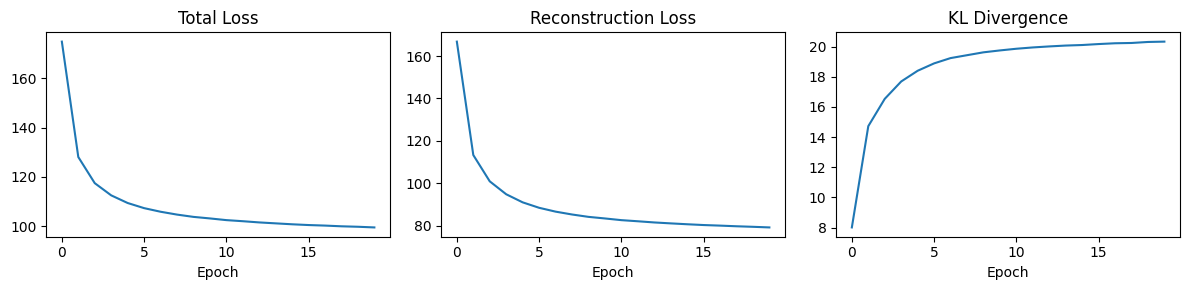

In [13]:
# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
axes[0].plot(history['loss'])
axes[0].set_title('Total Loss')
axes[1].plot(history['recon'])
axes[1].set_title('Reconstruction Loss')
axes[2].plot(history['kl'])
axes[2].set_title('KL Divergence')
for ax in axes:
    ax.set_xlabel('Epoch')
plt.tight_layout()
plt.show()

---
## 4. Exploring the VAE

### Reconstructions

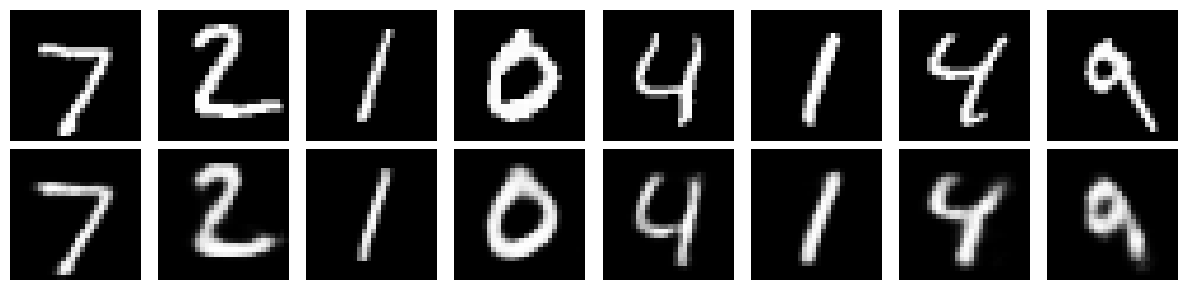

In [14]:
def visualize_vae_reconstructions(model, test_loader, n=8):
    """Show reconstructions with the encoded distribution info."""
    model.eval()
    x, _ = next(iter(test_loader))
    x = x[:n].to(device)
    
    with torch.no_grad():
        x_recon, mu, logvar = model(x)
        std = torch.exp(0.5 * logvar)
    
    fig, axes = plt.subplots(2, n, figsize=(n*1.5, 3))
    for i in range(n):
        axes[0, i].imshow(x[i].cpu().squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(x_recon[i].cpu().squeeze(), cmap='gray')
        axes[1, i].axis('off')
    axes[0, 0].set_ylabel('Original')
    axes[1, 0].set_ylabel('Reconstructed')
    plt.tight_layout()
    plt.show()

visualize_vae_reconstructions(vae, test_loader)

### Generation: Sampling from the Prior

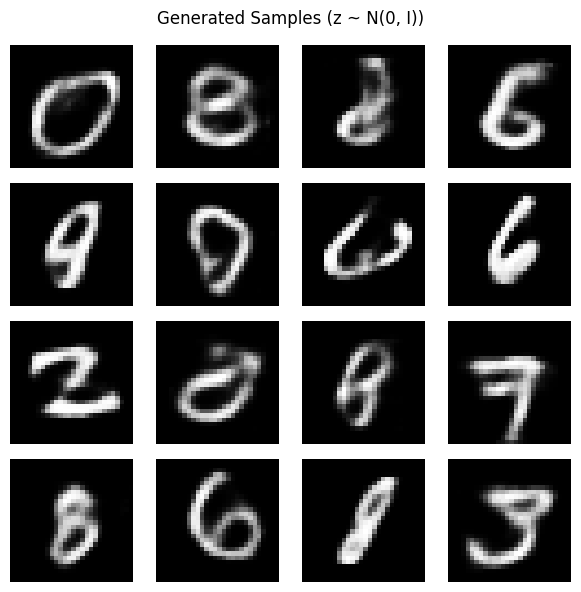

In [15]:
def generate_samples(model, n_samples=16):
    """Generate new samples by sampling from prior N(0, I)."""
    model.eval()
    with torch.no_grad():
        # Sample from prior
        z = torch.randn(n_samples, model.latent_dim).to(device)
        samples = model.decode(z)
    
    # Display
    n_rows = int(np.sqrt(n_samples))
    fig, axes = plt.subplots(n_rows, n_rows, figsize=(n_rows*1.5, n_rows*1.5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(samples[i].cpu().squeeze(), cmap='gray')
        ax.axis('off')
    plt.suptitle('Generated Samples (z ~ N(0, I))')
    plt.tight_layout()
    plt.show()

generate_samples(vae, n_samples=16)

### Latent Space Visualization

Epoch 5/30 - Loss: 148.3, Recon: 142.2, KL: 6.1
Epoch 10/30 - Loss: 142.9, Recon: 136.5, KL: 6.4
Epoch 15/30 - Loss: 140.5, Recon: 133.9, KL: 6.6
Epoch 20/30 - Loss: 139.0, Recon: 132.2, KL: 6.7
Epoch 25/30 - Loss: 137.8, Recon: 131.0, KL: 6.8
Epoch 30/30 - Loss: 137.1, Recon: 130.2, KL: 6.9


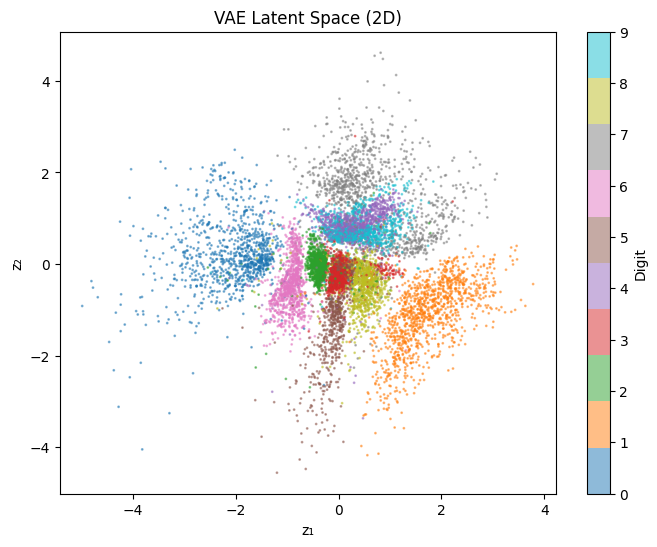

In [16]:
# Train a 2D VAE for visualization
vae_2d = VAE(latent_dim=2).to(device)
vae_2d, _ = train_vae(vae_2d, train_loader, epochs=30)

# Visualize latent space
vae_2d.eval()
latents, labels = [], []
with torch.no_grad():
    for x, y in test_loader:
        mu, _ = vae_2d.encode(x.to(device))
        latents.append(mu.cpu())
        labels.append(y)

latents = torch.cat(latents).numpy()
labels = torch.cat(labels).numpy()

plt.figure(figsize=(8, 6))
scatter = plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='tab10', alpha=0.5, s=1)
plt.colorbar(scatter, label='Digit')
plt.xlabel('z₁')
plt.ylabel('z₂')
plt.title('VAE Latent Space (2D)')
plt.show()

### Latent Space Interpolation

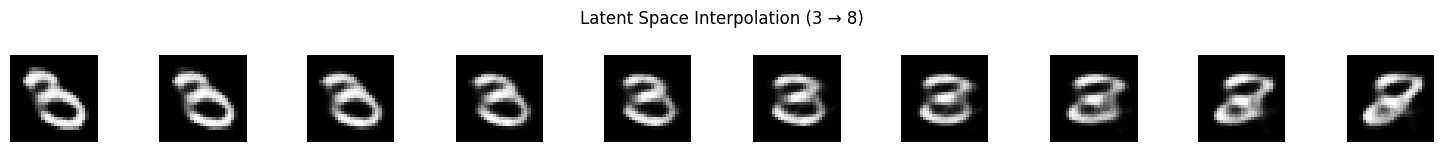

In [30]:
def interpolate_latent(model, x1, x2, steps=10):
    """Interpolate between two images in latent space."""
    model.eval()
    with torch.no_grad():
        mu1, _ = model.encode(x1)
        mu2, _ = model.encode(x2)
        
        # Linear interpolation in latent space
        interpolations = []
        for alpha in np.linspace(0, 1, steps):
            z = (1 - alpha) * mu1 + alpha * mu2
            img = model.decode(z)
            interpolations.append(img)
    
    return torch.cat(interpolations)

# Get two different digits
test_batch, test_labels = next(iter(test_loader))
idx1 = (test_labels == 3).nonzero()[0].item()
idx2 = (test_labels == 8).nonzero()[0].item()

x1 = test_batch[idx1:idx1+1].to(device)
x2 = test_batch[idx2:idx2+1].to(device)

interp = interpolate_latent(vae, x1, x2, steps=10)

fig, axes = plt.subplots(1, 10, figsize=(15, 1.5))
for i, ax in enumerate(axes):
    ax.imshow(interp[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')
plt.suptitle('Latent Space Interpolation (3 → 8)')
plt.tight_layout()
plt.show()

### Latent Space Traversal (2D Grid)

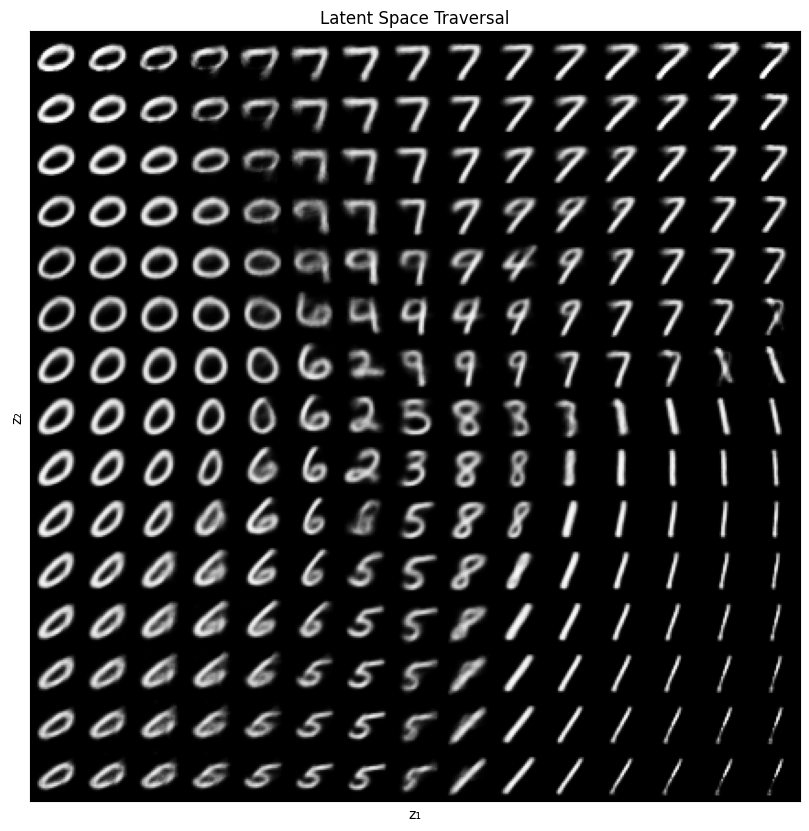

In [18]:
def plot_latent_grid(model, n=15, range_val=3):
    """Generate images by traversing 2D latent space on a grid."""
    model.eval()
    
    # Create grid of latent values
    grid_x = np.linspace(-range_val, range_val, n)
    grid_y = np.linspace(-range_val, range_val, n)[::-1]
    
    figure = np.zeros((28 * n, 28 * n))
    
    with torch.no_grad():
        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):
                z = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)
                img = model.decode(z).cpu().squeeze().numpy()
                figure[i*28:(i+1)*28, j*28:(j+1)*28] = img
    
    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='gray')
    plt.xlabel('z₁')
    plt.ylabel('z₂')
    plt.title('Latent Space Traversal')
    plt.xticks([])
    plt.yticks([])
    plt.show()

plot_latent_grid(vae_2d, n=15, range_val=3)

---
## 5. Convolutional VAE

For better image quality, we use convolutional layers:

In [19]:
class ConvVAE(nn.Module):
    """Convolutional VAE for MNIST."""
    
    def __init__(self, latent_dim=20):
        super().__init__()
        self.latent_dim = latent_dim
        
        # Encoder: 1x28x28 -> 32x14x14 -> 64x7x7 -> flatten -> latent
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),  # -> 32x14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # -> 64x7x7
            nn.ReLU(),
            nn.Flatten(),
        )
        self.fc_mu = nn.Linear(64 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(64 * 7 * 7, latent_dim)
        
        # Decoder: latent -> 64x7x7 -> 32x14x14 -> 1x28x28
        self.fc_decode = nn.Linear(latent_dim, 64 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # -> 32x14x14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1),   # -> 1x28x28
            nn.Sigmoid()
        )
    
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + std * eps
    
    def decode(self, z):
        h = self.fc_decode(z).view(-1, 64, 7, 7)
        return self.decoder(h)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Train ConvVAE
conv_vae = ConvVAE(latent_dim=20).to(device)
conv_vae, conv_history = train_vae(conv_vae, train_loader, epochs=20)

Epoch 5/20 - Loss: 106.5, Recon: 80.2, KL: 26.3
Epoch 10/20 - Loss: 103.7, Recon: 77.5, KL: 26.2
Epoch 15/20 - Loss: 102.4, Recon: 76.4, KL: 26.0
Epoch 20/20 - Loss: 101.6, Recon: 75.7, KL: 25.9


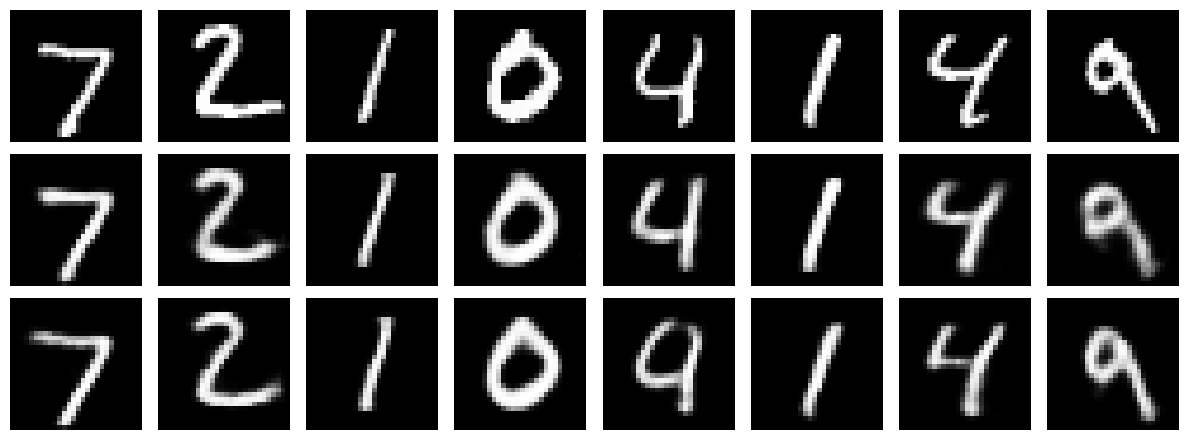

In [20]:
# Compare MLP VAE vs Conv VAE
fig, axes = plt.subplots(3, 8, figsize=(12, 4.5))

x, _ = next(iter(test_loader))
x = x[:8].to(device)

with torch.no_grad():
    mlp_recon, _, _ = vae(x)
    conv_recon, _, _ = conv_vae(x)

for i in range(8):
    axes[0, i].imshow(x[i].cpu().squeeze(), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(mlp_recon[i].cpu().squeeze(), cmap='gray')
    axes[1, i].axis('off')
    axes[2, i].imshow(conv_recon[i].cpu().squeeze(), cmap='gray')
    axes[2, i].axis('off')

axes[0, 0].set_ylabel('Original')
axes[1, 0].set_ylabel('MLP VAE')
axes[2, 0].set_ylabel('Conv VAE')
plt.tight_layout()
plt.show()

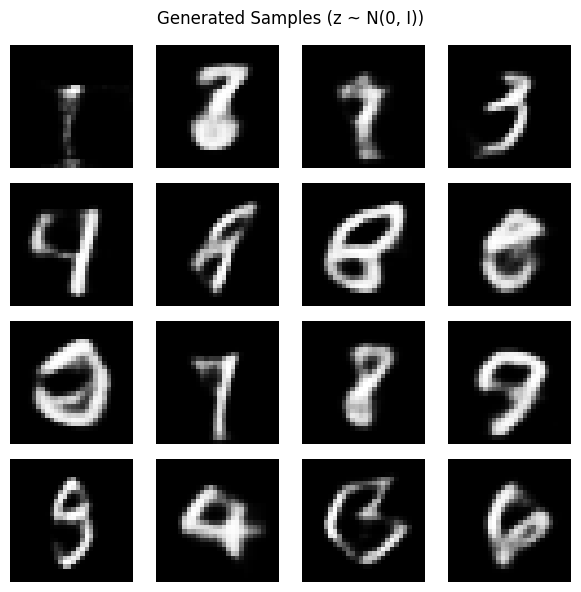

In [32]:
# Generate samples from ConvVAE
generate_samples(conv_vae, n_samples=16)

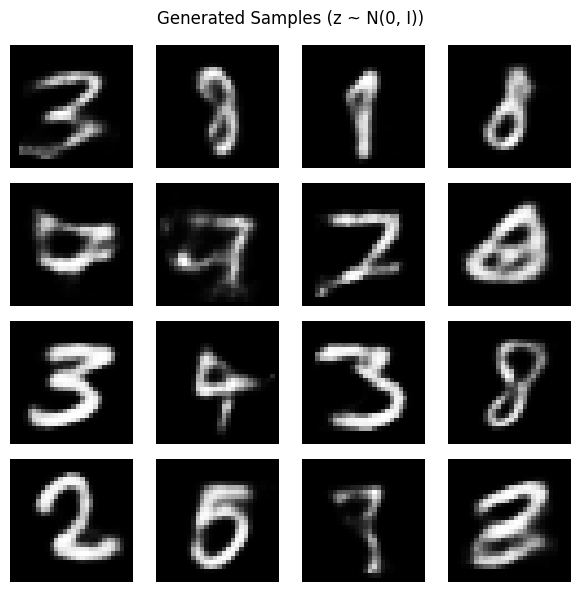

In [33]:
# Generate samples from VAE
generate_samples(vae, n_samples=16)

---
## 6. β-VAE: Disentangled Representations

**β-VAE** uses β > 1 to encourage disentangled latent representations where each dimension captures independent factors of variation.

In [22]:
# Train with different beta values
betas = [0.1, 1.0, 4.0]
models = {}

for beta in betas:
    print(f"\nTraining with β = {beta}")
    model = VAE(latent_dim=10).to(device)
    model, _ = train_vae(model, train_loader, epochs=15, beta=beta)
    models[beta] = model


Training with β = 0.1
Epoch 5/15 - Loss: 87.7, Recon: 84.3, KL: 34.3
Epoch 10/15 - Loss: 82.2, Recon: 78.8, KL: 33.5
Epoch 15/15 - Loss: 79.7, Recon: 76.3, KL: 33.5

Training with β = 1.0
Epoch 5/15 - Loss: 110.5, Recon: 93.8, KL: 16.7
Epoch 10/15 - Loss: 105.3, Recon: 87.6, KL: 17.7
Epoch 15/15 - Loss: 102.5, Recon: 84.1, KL: 18.4

Training with β = 4.0
Epoch 5/15 - Loss: 150.7, Recon: 121.6, KL: 7.3
Epoch 10/15 - Loss: 146.6, Recon: 115.1, KL: 7.9
Epoch 15/15 - Loss: 144.5, Recon: 112.0, KL: 8.1


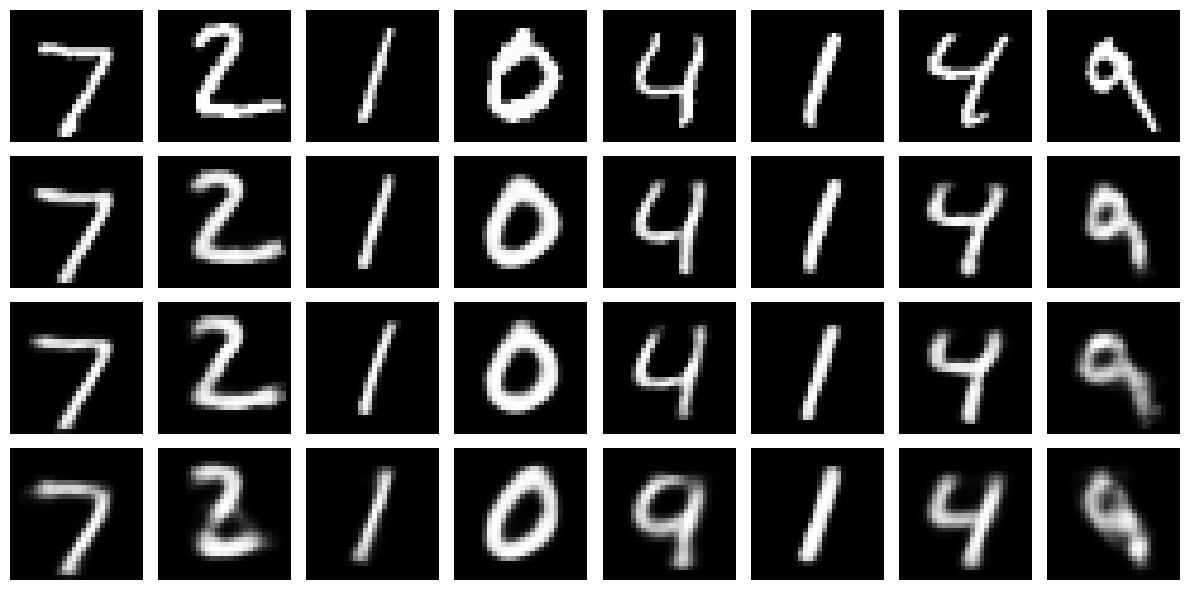

In [23]:
# Compare reconstructions and generations
fig, axes = plt.subplots(len(betas) + 1, 8, figsize=(12, 6))

x, _ = next(iter(test_loader))
x = x[:8].to(device)

# Original
for i in range(8):
    axes[0, i].imshow(x[i].cpu().squeeze(), cmap='gray')
    axes[0, i].axis('off')
axes[0, 0].set_ylabel('Original')

# Reconstructions for each beta
for row, beta in enumerate(betas, 1):
    with torch.no_grad():
        recon, _, _ = models[beta](x)
    for i in range(8):
        axes[row, i].imshow(recon[i].cpu().squeeze(), cmap='gray')
        axes[row, i].axis('off')
    axes[row, 0].set_ylabel(f'β={beta}')

plt.tight_layout()
plt.show()

**Trade-off**: Higher β = more regularized latent space (better disentanglement) but worse reconstruction quality.

---
## 7. Summary

### Key Concepts

| Concept | Description |
|---------|-------------|
| **Autoencoder** | Encoder-decoder that learns compressed representations |
| **VAE** | Probabilistic autoencoder with regularized latent space |
| **ELBO** | Evidence Lower Bound = Reconstruction - KL divergence |
| **Reparameterization** | z = μ + σ·ε enables backprop through sampling |
| **KL Divergence** | Measures how far q(z|x) is from prior p(z) |
| **β-VAE** | β > 1 encourages disentangled representations |

### VAE vs Autoencoder

| Aspect | Autoencoder | VAE |
|--------|-------------|-----|
| Latent | Deterministic point | Distribution (μ, σ²) |
| Generation | Poor (holes in latent space) | Good (structured space) |
| Interpolation | May be discontinuous | Smooth |
| Loss | Reconstruction only | Reconstruction + KL |

### When to Use VAEs

- **Good for**: Smooth latent spaces, interpolation, controllable generation
- **Limitations**: Blurry outputs (due to Gaussian assumption), mode averaging
- **Alternatives**: GANs for sharper images, Diffusion models for highest quality

---
## Exercises

### Exercise 1: Conditional VAE (CVAE)
Implement a Conditional VAE that can generate specific digits by conditioning on the class label.

### Exercise 2: Latent Dimension Analysis
Train VAEs with different latent dimensions (2, 10, 50, 100) and analyze the trade-off between reconstruction quality and generation diversity.

### Exercise 3: VAE for Fashion-MNIST
Adapt the ConvVAE to Fashion-MNIST and visualize the latent space - are clothing categories separable?

---
## Solutions

Epoch 5, Loss: 105.7
Epoch 10, Loss: 99.6
Epoch 15, Loss: 97.1


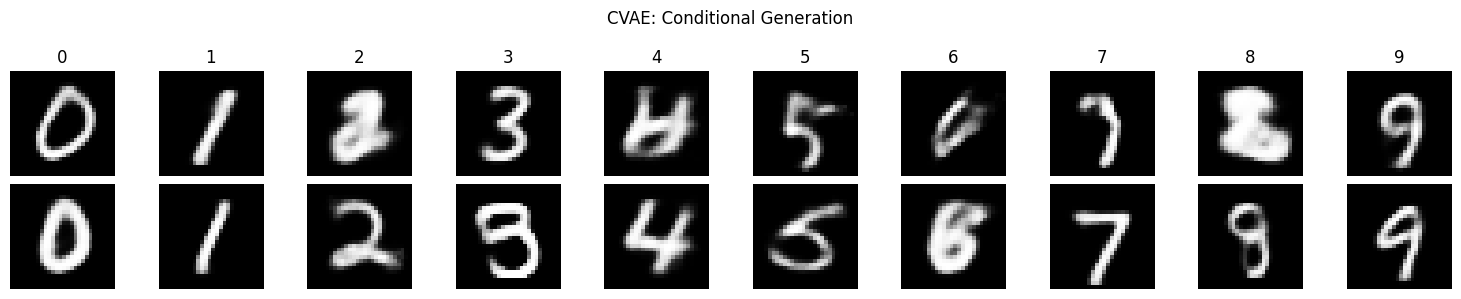

In [24]:
# Solution 1: Conditional VAE
class CVAE(nn.Module):
    """Conditional VAE - conditions on class label."""
    
    def __init__(self, latent_dim=20, num_classes=10):
        super().__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        
        # Encoder: input + one-hot label
        self.encoder = nn.Sequential(
            nn.Linear(784 + num_classes, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)
        
        # Decoder: latent + one-hot label
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Sigmoid()
        )
    
    def encode(self, x, y):
        y_onehot = F.one_hot(y, self.num_classes).float()
        h = torch.cat([x.view(-1, 784), y_onehot], dim=1)
        h = self.encoder(h)
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        return mu + std * torch.randn_like(std)
    
    def decode(self, z, y):
        y_onehot = F.one_hot(y, self.num_classes).float()
        h = torch.cat([z, y_onehot], dim=1)
        return self.decoder(h).view(-1, 1, 28, 28)
    
    def forward(self, x, y):
        mu, logvar = self.encode(x, y)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, y), mu, logvar

# Train CVAE
cvae = CVAE(latent_dim=20).to(device)
optimizer = torch.optim.Adam(cvae.parameters(), lr=1e-3)

for epoch in range(15):
    total_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        x_recon, mu, logvar = cvae(x, y)
        loss, _, _ = vae_loss(x_recon, x, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.1f}")

# Generate specific digits
cvae.eval()
fig, axes = plt.subplots(2, 10, figsize=(15, 3))
with torch.no_grad():
    for digit in range(10):
        z = torch.randn(2, 20).to(device)
        y = torch.tensor([digit, digit]).to(device)
        samples = cvae.decode(z, y)
        for row in range(2):
            axes[row, digit].imshow(samples[row].cpu().squeeze(), cmap='gray')
            axes[row, digit].axis('off')
        axes[0, digit].set_title(str(digit))
plt.suptitle('CVAE: Conditional Generation')
plt.tight_layout()
plt.show()


Training VAE with latent_dim=2
Epoch 5/10 - Loss: 149.2, Recon: 143.2, KL: 6.0
Epoch 10/10 - Loss: 143.7, Recon: 137.3, KL: 6.4

Training VAE with latent_dim=10
Epoch 5/10 - Loss: 109.8, Recon: 92.3, KL: 17.4
Epoch 10/10 - Loss: 104.5, Recon: 86.3, KL: 18.3

Training VAE with latent_dim=50
Epoch 5/10 - Loss: 111.9, Recon: 94.6, KL: 17.3
Epoch 10/10 - Loss: 104.4, Recon: 85.6, KL: 18.8

Training VAE with latent_dim=100
Epoch 5/10 - Loss: 112.9, Recon: 95.9, KL: 17.0
Epoch 10/10 - Loss: 105.7, Recon: 87.3, KL: 18.4


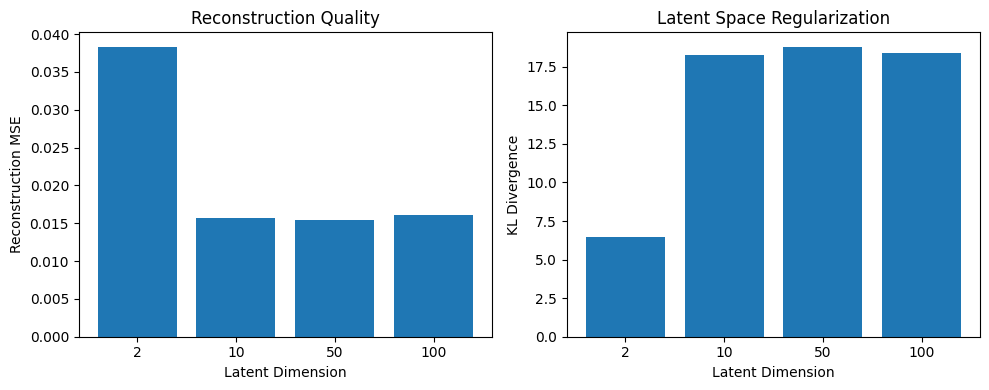


Analysis:
- Higher latent dim → better reconstruction (more capacity)
- Higher latent dim → higher KL (more dimensions to regularize)
- Sweet spot depends on data complexity (MNIST: 10-20 often sufficient)


In [25]:
# Solution 2: Latent Dimension Analysis
latent_dims = [2, 10, 50, 100]
results = {}

for dim in latent_dims:
    print(f"\nTraining VAE with latent_dim={dim}")
    model = VAE(latent_dim=dim).to(device)
    model, history = train_vae(model, train_loader, epochs=10)
    
    # Evaluate reconstruction
    model.eval()
    total_recon = 0
    with torch.no_grad():
        for x, _ in test_loader:
            x = x.to(device)
            x_recon, mu, logvar = model(x)
            total_recon += F.mse_loss(x_recon, x).item()
    
    results[dim] = {
        'model': model,
        'recon_mse': total_recon / len(test_loader),
        'final_kl': history['kl'][-1]
    }

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
dims = list(results.keys())
recons = [results[d]['recon_mse'] for d in dims]
kls = [results[d]['final_kl'] for d in dims]

axes[0].bar(range(len(dims)), recons)
axes[0].set_xticks(range(len(dims)))
axes[0].set_xticklabels(dims)
axes[0].set_xlabel('Latent Dimension')
axes[0].set_ylabel('Reconstruction MSE')
axes[0].set_title('Reconstruction Quality')

axes[1].bar(range(len(dims)), kls)
axes[1].set_xticks(range(len(dims)))
axes[1].set_xticklabels(dims)
axes[1].set_xlabel('Latent Dimension')
axes[1].set_ylabel('KL Divergence')
axes[1].set_title('Latent Space Regularization')

plt.tight_layout()
plt.show()

print("\nAnalysis:")
print("- Higher latent dim → better reconstruction (more capacity)")
print("- Higher latent dim → higher KL (more dimensions to regularize)")
print("- Sweet spot depends on data complexity (MNIST: 10-20 often sufficient)")

Epoch 5/20 - Loss: 245.1, Recon: 227.0, KL: 18.1
Epoch 10/20 - Loss: 242.2, Recon: 224.5, KL: 17.8
Epoch 15/20 - Loss: 241.0, Recon: 223.4, KL: 17.6
Epoch 20/20 - Loss: 240.2, Recon: 222.7, KL: 17.5


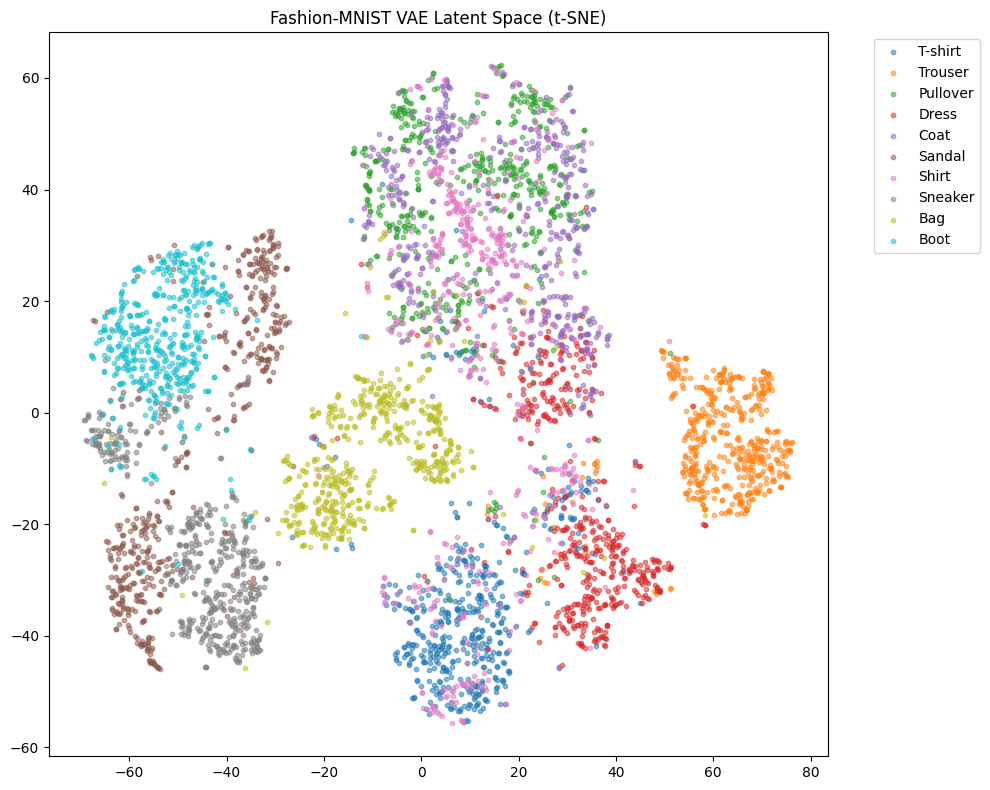

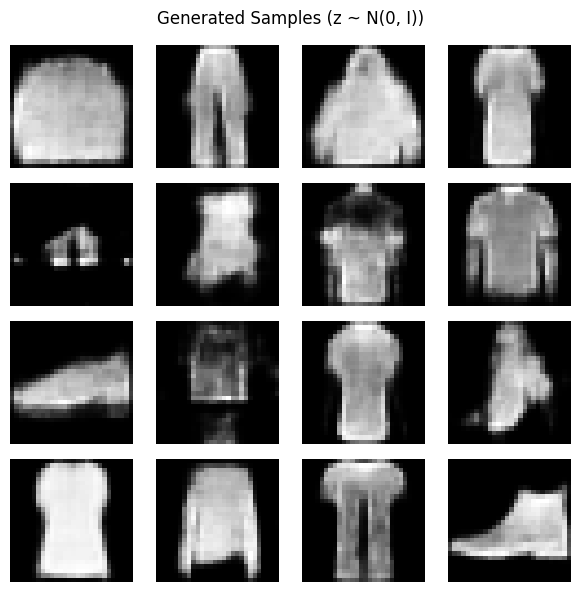

In [27]:
# Solution 3: Fashion-MNIST VAE
fashion_train = datasets.FashionMNIST('../data', train=True, download=True, transform=transform)
fashion_test = datasets.FashionMNIST('../data', train=False, transform=transform)
fashion_train_loader = DataLoader(fashion_train, batch_size=128, shuffle=True)
fashion_test_loader = DataLoader(fashion_test, batch_size=128)

fashion_classes = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Boot']

# Train ConvVAE on Fashion-MNIST
fashion_vae = ConvVAE(latent_dim=20).to(device)
fashion_vae, _ = train_vae(fashion_vae, fashion_train_loader, epochs=20)

# Visualize latent space with t-SNE (since 20D)
from sklearn.manifold import TSNE

fashion_vae.eval()
latents, labels = [], []
with torch.no_grad():
    for x, y in fashion_test_loader:
        mu, _ = fashion_vae.encode(x.to(device))
        latents.append(mu.cpu())
        labels.append(y)
        if len(latents) * 128 >= 5000:
            break

latents = torch.cat(latents).numpy()[:5000]
labels = torch.cat(labels).numpy()[:5000]

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
latents_2d = tsne.fit_transform(latents)

plt.figure(figsize=(10, 8))
for i in range(10):
    mask = labels == i
    plt.scatter(latents_2d[mask, 0], latents_2d[mask, 1], 
                label=fashion_classes[i], alpha=0.5, s=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Fashion-MNIST VAE Latent Space (t-SNE)')
plt.tight_layout()
plt.show()

# Generate samples
generate_samples(fashion_vae, n_samples=16)